In [29]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torchvision import transforms
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import time

import pandas as pd

In [30]:
path = "/home/borowis/s3"
bs = 512

In [31]:
trans = transforms.Compose([
    transforms.RandomAffine(10, shear=5),
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = ImageFolder(path + "/train_data/medium", trans)
train_loader = DataLoader(train_data, bs, shuffle=True, num_workers=8)

In [32]:
val_data = ImageFolder(path + "/validation_classification/medium", trans)
val_loader = DataLoader(val_data, bs, shuffle=True, num_workers=8)

In [33]:
class SimpleNet(nn.Module):
        
    def __init__(self):
        super(SimpleNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(p=0.05))

        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer6 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())

        self.drop_out1 = nn.Dropout(p=0.3)
        
        self.fc1 = nn.Linear(4 * 4 * 128, 4096)
        self.bc1 = nn.BatchNorm1d(4096)
        self.ac1 = nn.ReLU()
        
        self.drop_out2 = nn.Dropout()
        self.fc2 = nn.Linear(4096, 2300)
        
    def forward(self, x):
        
        x = self.layer1(x) #32
        x = self.layer2(x) #16
        x = self.layer3(x) #16
        x = self.layer4(x) #8
        x = self.layer5(x) #4
        x = self.layer6(x) #4

        #Reshape data to input to the input layer of the neural net
        #Size changes from (128, 4, 4) to (1, 2048)
        x = x.view(-1, 128 * 4 * 4)
        x = self.drop_out1(x)
        
        #Computes the activation of the first fully connected layer
        #Size changes from (1, 2048) to (1, 2300)
        x = self.fc1(x)
        x = self.bc1(x)
        x = self.ac1(x)
        
        x = self.drop_out2(x)
        x = self.fc2(x)
        
        return F.log_softmax(x)

In [34]:
model = SimpleNet()

criterion = nn.CrossEntropyLoss()
print(model)

optimizer = optim.Adam(model.parameters())

SimpleNet(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.05)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2,

In [35]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    model.cuda()

    running_loss = 0.0
    
    start_time = time.time()
    for batch_idx, (data, target) in enumerate(train_loader):   
        optimizer.zero_grad()   
        data = data.cuda()
        target = target.long().cuda()

        outputs = model(data)
        loss = criterion(outputs, target)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
    
    end_time = time.time()
    
    running_loss /= len(train_loader)
    print('Training Loss: ', running_loss, 'Time: ',end_time - start_time, 's')
    return running_loss

In [36]:
def test_model(model, val_loader, criterion):
    with torch.no_grad():
        model.eval()
        model.cuda()

        running_loss = 0.0
        total_predictions = 0.0
        correct_predictions = 0.0

        for batch_idx, (data, target) in enumerate(val_loader):   
            data = data.cuda()
            target = target.long().cuda()

            outputs = model(data)

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += target.size(0)
            correct_predictions += (predicted == target).sum().item()

            loss = criterion(outputs, target)
            running_loss += loss.item()

        running_loss /= len(val_loader)
        acc = (correct_predictions/total_predictions)*100.0
        print('Validation Loss: ', running_loss)
        print('Validation Accuracy: ', acc, '%')
        return running_loss, acc

In [37]:
n_epochs = 12
train_loss = []
val_loss = []
val_acc = []

In [38]:
for i in range(n_epochs):
    tl = train_epoch(model, train_loader, criterion, optimizer)
    vl, va = test_model(model, val_loader, criterion)
    
    train_loss.append(tl)
    val_loss.append(vl)
    val_acc.append(va)
    print('='*20)
    
    # https://discuss.pytorch.org/t/saving-and-loading-a-model-in-pytorch/2610/16
    torch.save({
        'epoch': i + 1,
        'state_dict': model.state_dict(),
        'best_acc': val_acc,
        'optimizer' : optimizer.state_dict(),
    }, path + "/models/" + str(i) + ".pth")

/home/borowis/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training Loss:  4.9392664794755605 Time:  183.20704770088196 s
Validation Loss:  3.316765069961548
Validation Accuracy:  35.122799391436644 %
Training Loss:  3.2028089858229696 Time:  183.25606298446655 s
Validation Loss:  2.576634857389662
Validation Accuracy:  47.88089545750924 %
Training Loss:  2.650769949998535 Time:  183.1950125694275 s
Validation Loss:  2.2607841226789684
Validation Accuracy:  53.98826342099543 %
Training Loss:  2.3407501506330366 Time:  183.09739685058594 s
Validation Loss:  2.048248357243008
Validation Accuracy:  57.965659639208866 %
Training Loss:  2.120661928377591 Time:  183.13306951522827 s
Validation Loss:  1.906329247686598
Validation Accuracy:  60.39991306237774 %
Training Loss:  1.961753857685056 Time:  183.23572850227356 s
Validation Loss:  1.7865956756803725
Validation Accuracy:  62.72549445772658 %
Training Loss:  1.8330877749144956 Time:  183.180278301239 s
Validation Loss:  1.7458883788850572
Validation Accuracy:  63.70354270810693 %
Training Loss:

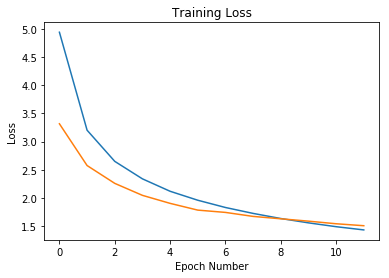

In [39]:
plt.title('Training Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(train_loss)
plt.plot(val_loss)

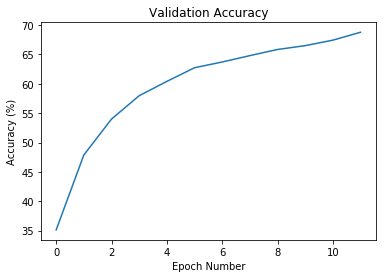

In [40]:
plt.title('Validation Accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy (%)')
plt.plot(val_acc)

In [49]:
checkpoint = torch.load(path + "/models/8.pth")
model.load_state_dict(checkpoint["state_dict"])

In [50]:
test_trans = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_data = ImageFolder(path + "/test_classification", test_trans)
test_loader = DataLoader(test_data, shuffle = False, batch_size = bs, num_workers = 8)

In [57]:
def inference(model, test_loader):
    with torch.no_grad():
        model.eval()
        model.cuda()

        preds = []
        for batch_idx, data in enumerate(test_loader):   
            data = data[0].cuda()
            outputs = model(data)

            _, predicted = torch.max(outputs, 1)
            preds.append(predicted.cpu().numpy())

        return np.concatenate(preds)

In [58]:
preds = inference(model, test_loader)

/home/borowis/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [59]:
class_to_idx = train_data.class_to_idx
idx_to_class = {val: key for key, val in class_to_idx.items()}

In [60]:
ids = []
for idx, (pred, (file, _)) in enumerate(zip(preds, test_data.samples)):
    file_name = file[file.rfind('/') + 1 : file.rfind('.')]
    ids.append(int(file_name))

In [61]:
submit = pd.DataFrame({'label': preds}, index=ids)

submit.label = submit.label.map(idx_to_class)
submit.sort_index().head(20)

,label
0,1613
1,1364
2,838
3,970
4,505
5,1040
6,1952
7,711
8,20
9,974


In [56]:
submit.sort_index().to_csv(path + "/model3.csv", index=True, index_label='id')

## Verification

In [138]:
ver_trans = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

ver_data = ImageFolder(path + "/validation_verification", ver_trans)
ver_loader = DataLoader(ver_data, bs, shuffle=False, num_workers=8)

In [139]:
verification_model = nn.Sequential(*list(model.children())[:-6])

In [141]:
def verification(model, loader):
    with torch.no_grad():
        model.eval()
        model.cuda()

        preds = []
        for batch_idx, (data, _) in enumerate(loader):   
            data = data.cuda()
            outputs = model(data)

            y = outputs.detach().cpu().numpy()
            y = y.reshape(-1, 128 * 4 * 4)
            
            preds.append(y)

        return np.concatenate(preds)

In [142]:
verification_data = verification(verification_model, ver_loader)

In [149]:
name_to_idx = { name.replace(path + '/validation_verification/', '') : idx 
                for idx, (name, _) in enumerate(ver_data.samples) }   

In [193]:
from sklearn.metrics.pairwise import cosine_similarity

verification_scores = open(path + '/verification_scores.csv', 'w')
for line in open(path + '/validation_trials_verification.txt'):
    (first, second, score) = line.split(' ')
    data_first = verification_data[name_to_idx[first]].reshape(1, -1)
    data_second = verification_data[name_to_idx[second]].reshape(1, -1)
    
    verification_scores.write(str(np.squeeze(cosine_similarity(data_first, data_second))) + "\n")

verification_scores.close()

In [194]:
from sklearn.metrics import roc_auc_score
import sys
import pandas as pd

y_score = pd.read_csv(path + '/verification_scores.csv', header=None)[0].values
y_true = pd.read_csv(path + '/validation_trials_verification.txt', delimiter=' ', header=None)[2].values

auc = roc_auc_score(y_true, y_score)
print(auc)

0.8524545641306501


## Submit verification

In [208]:
test_ver_data = ImageFolder(path + "/test_verification", ver_trans)
test_ver_loader = DataLoader(test_ver_data, bs, shuffle=False, num_workers=8)

In [209]:
test_verification_data = verification(verification_model, test_ver_loader)

In [210]:
test_name_to_idx = { name.replace(path + '/test_verification/unknown/', '') : idx 
                     for idx, (name, _) in enumerate(test_ver_data.samples) }   

test_verification_scores = open(path + '/test_verification_scores.csv', 'w')
test_verification_scores.write('trial,score\n')
idx = 0
for line in open(path + '/test_trials_verification_student.txt'):
    (first, second) = line.strip().split(' ')
    data_first = test_verification_data[test_name_to_idx[first]].reshape(1, -1)
    data_second = test_verification_data[test_name_to_idx[second]].reshape(1, -1)
    
    test_verification_scores.write(line.strip() + "," + str(np.squeeze(cosine_similarity(data_first, data_second))) + "\n")
    idx += 1

test_verification_scores.close()